Lab03
=====

## Context
#### Sequence Modeling Exercise
+ Tensorflow Speech Recognition Dataset

## 음성 데이터를 순환신경망으로 분류해보기
오늘 배운 RNN과 LSTM을 이용해 음성 데이터를 분류하는 모델을 만들어보겠습니다.<br>


In [1]:
#path 관련 라이브러리
import os
from os.path import join, isdir

# Scientific Math 라이브러리  
import numpy as np
from sklearn.model_selection import train_test_split

# Visualization 라이브러리
import matplotlib.pyplot as plt
import IPython.display as ipd

import tensorflow as tf
import keras
from keras import layers, models, Input
from keras.utils import to_categorical

from scipy import signal
from scipy.io import wavfile

datapath = join('..', 'Day2_Lab01', 'data', 'Tensorflow_Speech_Recognition', 'audio')

Using TensorFlow backend.


In [2]:
# Keras 백 엔드인 TensorFlow의 세션 설정을 불러옵니다.
from keras.backend.tensorflow_backend import set_session

# TensorFlow의 ConfigProto() 객체에 학습시 적용할 옵션들을 명시적으로 설정할 수 있습니다.
config = tf.ConfigProto()

# GPU 옵션으로 allow_grouth를 True로 설정합니다.
config.gpu_options.allow_growth = True

# TensorFlow는 Session이라는 실행 단위를 가지고 있는데, 해당 Session이라는에 적용할 옵션을 담고있는 
sess = tf.Session(config=config)

# 설정한 Session이라는을 현재 프로세스에 적용합니다.
set_session(sess)

## 1. 데이터 살펴보기 

작년 1월에 Kaggle 플랫폼에서 진행된 Competition의 데이터셋으로 구글 AI에서 제공한 데이터입니다.<br>
<img src = "./Images/Tensorflow_Speech_Recognition.png" style = height:600px/>

이번 시간에는 그 중 10가지 label의 데이터를 분류하는 것을 목표로 합니다.

(Target Label : yes, no, up, down, left, right, on, off, stop, go)


data 디렉토리에 디렉토리 별로 정리된 데이터와 라벨을 가져옵니다.

In [3]:
# 데이터 샘플 불러오기
filename = join('/down', 'cb8f8307_nohash_0.wav')
sample_rate, samples = wavfile.read(datapath + filename)
print('Wav 형태일 때 차원 : {}'.format(samples.shape))
ipd.Audio(samples, rate= sample_rate)

Wav 형태일 때 차원 : (16000,)


## 2. 간단한 전처리

#### 2.1 학습 파라미터를 줄이기 위해 더 낮은 초당 샘플수를 가지는 신호로 resampling 해줍니다.

In [4]:
sample_rate = 3000
f = signal.resample(samples, sample_rate)
ipd.Audio(f, rate= sample_rate)

####  2.2 Target 데이터를 설정합니다.

디렉토리 별로 정리된 데이터를 불러와 라벨을 붙입니다.

In [5]:
# os.listdir(경로) 함수는 경로에 존재하는 모든 파일 이름을 리스트로 반환합니다.
dirs = [f for f in os.listdir(datapath) if isdir(join(datapath, f))]
dirs.sort()

In [6]:
#데이터 읽기
target_value = dict()
x = list()
y = list()
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
i=0;
for direct in dirs[1:]:
    if direct not in target_list:
        continue
    # 각 디렉토리에 대해 파일명 리스트를 만듭니다.
    waves = [f for f in os.listdir(join(datapath, direct)) if f.endswith('.wav')]
    target_value[direct] = i
    i = i + 1
    print(str(i)+":" +str(direct) + " ", end="")
    
    #만든 파일명 리스트를 바탕으로 음성 파일을 읽습니다.
    for wav in waves:
        sample_rate, samples = wavfile.read(datapath+'/'+direct+'/'+wav)

       
        if samples.shape[0] != 16000 :
            continue
        resampled_signal=signal.resample(samples, 3000)
        x.append(resampled_signal)
        y.append(direct)

1:down 2:go 3:left 4:no 5:off 6:on 7:right 8:stop 9:up 10:yes 

In [7]:
print('x :\n', np.shape(x))
print('y :\n', np.shape(y))

x :
 (599, 3000)
y :
 (599,)


Keras 에서 RNN(LSTM 동일) 을 사용하기 위해 입력 데이터를 (nb_samples, timesteps, input_dim) 크기를 가지는 ndim=3인 3차원 텐서(tensor) 형태로 변환합니다.

In [8]:
x = np.reshape(x, (-1, 3000, 1))

Train/Test 데이터를 나눕니다.

In [9]:
# 데이터를 훈련 데이터와, 검증 데이터로 나눕니다.
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.1,
                                                    random_state = 2019,
                                                    shuffle=True)

In [10]:
print('x_train 차원 : ' + str(np.shape(x_train)))

print('y_train 차원 : ' + str(np.shape(y_train)))

print('x_test 차원 : ' + str(np.shape(x_test)))

print('y_test 차원 : ' + str(np.shape(y_test)))

x_train 차원 : (539, 3000, 1)
y_train 차원 : (539,)
x_test 차원 : (60, 3000, 1)
y_test 차원 : (60,)


y값에 들어있는 범주형 데이터를 숫자 라벨로 변경 후 독립적인 벡터 형태로 표현합니다.<br>(One-hot encoding)

In [11]:
# 레이블을 숫자형태로 변경
temp = []
for v in y_train:
    temp.append(target_value[v])
y_train = np.array(temp)

temp = []
for v in y_test:
    temp.append(target_value[v])
y_test = np.array(temp)

# 레이블을 one hot encoding으로 변환
y_train = keras.utils.to_categorical(y_train, len(target_value))
y_test = keras.utils.to_categorical(y_test, len(target_value))

In [12]:
print('x_train 차원 : ' + str(np.shape(x_train)))

print('y_train 차원 : ' + str(np.shape(y_train)))

print('x_test 차원 : ' + str(np.shape(x_test)))

print('y_test 차원 : ' + str(np.shape(y_test)))

x_train 차원 : (539, 3000, 1)
y_train 차원 : (539, 10)
x_test 차원 : (60, 3000, 1)
y_test 차원 : (60, 10)


## 3. Keras로 순환신경망(RNN, LSTM) 모델 만들어보기

In [13]:
# 파라미터 설정
lr = 0.001
epoch = 1
batch_size = 256
drop_out_rate = 0.3

In [14]:
# 입력 텐서
# input_shape : input_length 인수로는 순서열의 길이, input_dim 인수로는 벡터의 크기를 입력합니다.
# batch size를 제외한 크기를 입력합니다.
input_shape = (len(x_train[0]),1)
input_tensor = layers.Input(input_shape)

In [15]:
# 가장 단순한 신경망 구조인 SimpleRNN 클래스를 사용합니다.
# 첫번째 인수 : RNN cell 출력의 크기(차원)를 입력합니다.

lstm_layer_1 = layers.CuDNNLSTM(3000)(input_tensor)

# Dense 레이어를 통과시켜 Target의 차원과 layer의 ouput의 차원을 맞춰줍니다.
dense_layer_1 = layers.Dense(100, activation='relu')(lstm_layer_1)
drop_out_layer_1 = layers.Dropout(drop_out_rate)(dense_layer_1)

dense_layer_2 = layers.Dense(33, activation='relu')(drop_out_layer_1)
drop_out_layer_2 = layers.Dropout(drop_out_rate)(dense_layer_2)

output_tensor = layers.Dense(10, activation="softmax")(drop_out_layer_2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
# 모델 컴파일.
model = models.Model(input_tensor, output_tensor)
model.compile(optimizer = 'Adam',
              # 범주 분류이므로 categorical_crossentropy
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3000, 1)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 3000)              36036000  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               300100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 33)                3333      
_________________________________________________________________
dropout_2 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                340       
Total para

In [26]:
history = model.fit(x_train, y_train,
                    validation_data=[ x_test, y_test],
                    batch_size = 10,
                    epochs=epoch,
                    verbose=1
                   )

Train on 539 samples, validate on 60 samples
Epoch 1/1
539/539 [==============================] - 194s 359ms/step - loss: 2.3423 - acc: 0.1095 - val_loss: 2.3326 - val_acc: 0.1000


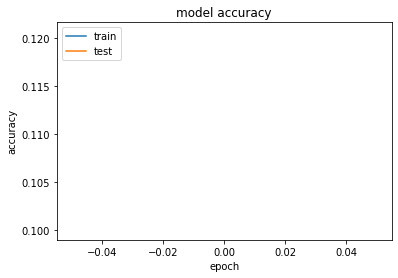

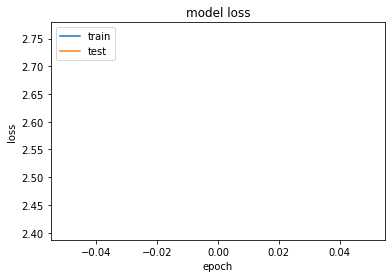

In [19]:
# 정확도 기록 시각화
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 비용 함수 기록 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 4.  CNN 모델과의 비교

In [20]:
# 입력 텐서
# input_shape : input_length 인수로는 순서열의 길이, input_dim 인수로는 벡터의 크기를 입력합니다.
# batch size를 제외한 크기를 입력합니다.
input_shape = (len(x_train[0]),1)
input_tensor = layers.Input(input_shape)

In [21]:
conv_layer_1 = layers.Conv1D(8, 3 ,padding='same', activation = 'relu')(input_tensor)
pool_layer_1 = layers.MaxPooling1D(padding='same')(conv_layer_1)
drop_out_layer_1 = layers.Dropout(0.5)(pool_layer_1)
batch_normal_1 = layers.BatchNormalization()(drop_out_layer_1)

conv_layer_2 = layers.Conv1D(16, 3,padding='same', activation = 'relu')(pool_layer_1)
pool_layer_2 = layers.MaxPooling1D(padding='same')(conv_layer_2)
drop_out_layer_2 = layers.Dropout(0.5)(pool_layer_2)
batch_normal_2 = layers.BatchNormalization()(drop_out_layer_2)

conv_layer_3 = layers.Conv1D(32, 3, activation = 'relu')(batch_normal_2)
pool_layer_3 = layers.MaxPooling1D()(conv_layer_3)
drop_out_layer_3 = layers.Dropout(0.5)(pool_layer_3)
batch_normal_3 = layers.BatchNormalization()(drop_out_layer_3)

conv_layer_4 = layers.Conv1D(64, 3, activation = 'relu')(batch_normal_3)
pool_layer_4 = layers.MaxPooling1D()(conv_layer_4)
drop_out_layer_4 = layers.Dropout(0.5)(pool_layer_4)
batch_normal_4 = layers.BatchNormalization()(drop_out_layer_4)

flat = layers.Flatten()(batch_normal_4)
dense_layer_1 = layers.Dense(256, activation='relu')(flat)
drop_out_layer_5 = layers.Dropout(0.5)(dense_layer_1)
batch_normal_5 = layers.BatchNormalization()(drop_out_layer_5)

dense_layer_2 = layers.Dense(128, activation='relu')(batch_normal_5)
drop_out_layer_6 = layers.Dropout(0.5)(dense_layer_2)
batch_normal_6 = layers.BatchNormalization()(drop_out_layer_6)


drop_out_layer_7 = layers.Dropout(0.5)(batch_normal_6)
batch_normal_7 = layers.BatchNormalization()(drop_out_layer_7)
output_tensor1 = layers.Dense(10, activation='softmax')(batch_normal_7)

In [22]:
512# 모델 컴파일.
model2 = models.Model(input_tensor, output_tensor1)
model2.compile(
             optimizer = keras.optimizers.Adam(lr = 0.003),
              # 범주 분류이므로 categorical_crossentropy
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [23]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3000, 8)           32        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1500, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1500, 16)          400       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 750, 16)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 750, 16)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 750, 16)           64        
__________

In [24]:
history = model2.fit(x_train, y_train, 
          validation_data=[ x_test, y_test],
          batch_size=512,                     
          epochs=10,
          verbose=2)

Train on 539 samples, validate on 60 samples
Epoch 1/10
 - 2s - loss: 3.0204 - acc: 0.1002 - val_loss: 2.8472 - val_acc: 0.1500
Epoch 2/10
 - 0s - loss: 2.7906 - acc: 0.1206 - val_loss: 2.7799 - val_acc: 0.1333
Epoch 3/10
 - 0s - loss: 2.8310 - acc: 0.1243 - val_loss: 2.6291 - val_acc: 0.1333
Epoch 4/10
 - 0s - loss: 2.7801 - acc: 0.1076 - val_loss: 2.6093 - val_acc: 0.1333
Epoch 5/10
 - 0s - loss: 2.8085 - acc: 0.1095 - val_loss: 2.5644 - val_acc: 0.1333
Epoch 6/10
 - 0s - loss: 2.8131 - acc: 0.0983 - val_loss: 2.5309 - val_acc: 0.1333
Epoch 7/10
 - 0s - loss: 2.7031 - acc: 0.1187 - val_loss: 2.5101 - val_acc: 0.1500
Epoch 8/10
 - 0s - loss: 2.6715 - acc: 0.1187 - val_loss: 2.4825 - val_acc: 0.1500
Epoch 9/10
 - 0s - loss: 2.7032 - acc: 0.1113 - val_loss: 2.4720 - val_acc: 0.1333
Epoch 10/10
 - 0s - loss: 2.6982 - acc: 0.1169 - val_loss: 2.4651 - val_acc: 0.1333


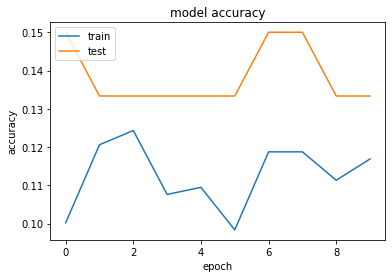

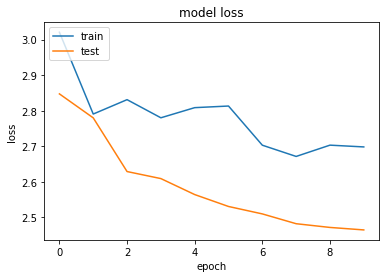

In [25]:
# 정확도 기록 시각화
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# 비용 함수 기록 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Reference
+ Tensorflow Speech Recognition : https://www.kaggle.com/c/tensorflow-speech-recognition-challenge